<a href="https://colab.research.google.com/github/YasinnSoylu/actt/blob/main/fastai2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
# ! unzip skin-cancer-mnist-ham10000.zip
#  !pip install timm


In [2]:

from fastai.vision.all import *
from fastai.metrics import *
import pandas as pd
from pathlib import Path
from timm import create_model

In [3]:

csv_path = "/content/HAM10000_metadata.csv"
skin_df = pd.read_csv(csv_path)
skin_df.sort_values(by="image_id")

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


In [4]:

path = Path('/content/')
Path.BASE_PATH = path
path.ls()
     

(#14) [Path('.config'),Path('hmnist_8_8_L.csv'),Path('ham10000_images_part_1'),Path('hmnist_28_28_L.csv'),Path('skin-cancer-mnist-ham10000.zip'),Path('HAM10000_images_part_2'),Path('ham10000_images_part_2'),Path('kaggle.json'),Path('models'),Path('HAM10000_metadata.csv')...]

In [5]:

short_to_full_name_dict = {
    "akiec" : "Bowen's disease", # very early form of skin cancer 
    "bcc" : "basal cell carcinoma" , # basal-cell cancer or white skin cancer
    "bkl" : "benign keratosis-like lesions", # non-cancerous skin tumour
    "df" : "dermatofibroma", # non-cancerous rounded bumps 
    "mel" : "melanoma", # black skin cancer
    "nv" : "melanocytic nevi", # mole non-cancerous
    "vasc" : "vascular lesions", # skin condition
}
 

In [6]:

# returns only dx and image id column
img_to_class_dict = skin_df.loc[:, ["image_id", "dx"]] 
# returns columns as lists in a dict
img_to_class_dict = img_to_class_dict.to_dict('list')  
# returns a dict mapping image id to disease name
img_to_class_dict = {img_id : short_to_full_name_dict[disease] for img_id,disease in zip(img_to_class_dict['image_id'], img_to_class_dict['dx']) } 
[x for x in img_to_class_dict.items()][:5]

[('ISIC_0027419', 'benign keratosis-like lesions'),
 ('ISIC_0025030', 'benign keratosis-like lesions'),
 ('ISIC_0026769', 'benign keratosis-like lesions'),
 ('ISIC_0025661', 'benign keratosis-like lesions'),
 ('ISIC_0031633', 'benign keratosis-like lesions')]

In [7]:

# path.stem returns the filename without suffix
def get_label_from_dict(path):
    return img_to_class_dict[path.stem] 

In [8]:

dblock = DataBlock(
    # Designation the independent and dependent variables
    blocks = (ImageBlock, CategoryBlock), 
    # To get a list of those files,and returns a list of all of the images in that path
    get_items = get_image_files, 
    # Split our training and validation sets randomly
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    # We are telling fastai what function to call to create the labels in our dataset, in our case is independet variable
    get_y = get_label_from_dict,
    # DihedralItem all 4 90 deg roatations and for each: 
    #2 horizonntal flips -> 8 orientations
    item_tfms=[Resize(448), DihedralItem()],
    # Picks a random scaled crop of an image and resize it to size
    batch_tfms=RandomResizedCrop(size=128, min_scale=0.75, max_scale=1.0))

img_path = "/content/"
# create dataloader using img_path   
data= dblock.dataloaders(img_path, bs=64) # bs = batch size

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


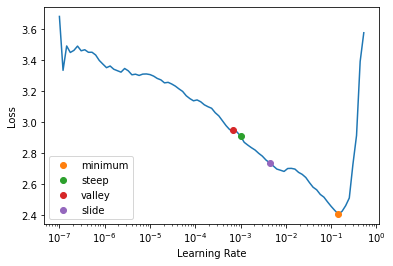

In [9]:
learn = vision_learner(data,resnet34,metrics=accuracy)
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [11]:
learn.fit_one_cycle(5,lrs.valley)


epoch,train_loss,valid_loss,accuracy,time
0,1.165137,1.587343,0.643784,05:41
1,0.808153,0.686231,0.765602,05:34
2,0.624772,0.578056,0.783824,05:35
3,0.444529,0.405668,0.857713,05:34
4,0.376981,0.333270,0.876935,05:36


In [12]:
learn.fit_one_cycle(5,lrs.slide)


epoch,train_loss,valid_loss,accuracy,time
0,0.872376,2.290627,0.329256,05:33
1,0.793602,0.763582,0.702696,05:28
2,0.731700,0.689829,0.730404,05:28
3,0.640567,0.590906,0.769346,05:28
4,0.563792,0.556996,0.788817,05:29


In [13]:
learn.fit_one_cycle(5,lrs.steep)


epoch,train_loss,valid_loss,accuracy,time
0,0.587619,0.732725,0.778332,05:29
1,0.596953,0.614786,0.781078,05:29
2,0.574784,0.531197,0.798053,05:29
3,0.537346,0.497033,0.805542,05:30
4,0.481748,0.478026,0.816026,05:31


In [14]:
learn.fit_one_cycle(5,slice(lrs.minimum,lrs.slide))


epoch,train_loss,valid_loss,accuracy,time
0,0.795537,0.806364,0.720419,05:28
1,0.745659,0.769898,0.724663,05:25
2,0.669645,0.685483,0.742636,05:26
3,0.619802,0.577800,0.780829,05:26
4,0.562903,0.554809,0.786820,05:26


In [15]:
learn.fit_one_cycle(5,slice(lrs.steep,lrs.valley))


epoch,train_loss,valid_loss,accuracy,time
0,0.552960,0.557547,0.784324,05:23
1,0.562804,0.540641,0.792312,05:23
2,0.548897,0.534876,0.793310,05:23
3,0.531273,0.522079,0.793560,05:27
4,0.545162,0.526033,0.793310,05:27


In [16]:
learn.fit_one_cycle(5,slice(lrs.steep,lrs.slide))


epoch,train_loss,valid_loss,accuracy,time
0,0.566700,0.598234,0.784074,05:26
1,0.575525,0.553376,0.785322,05:26
2,0.546957,0.517192,0.795307,05:27
3,0.507027,0.487099,0.809286,05:26
4,0.497650,0.487221,0.809036,05:26


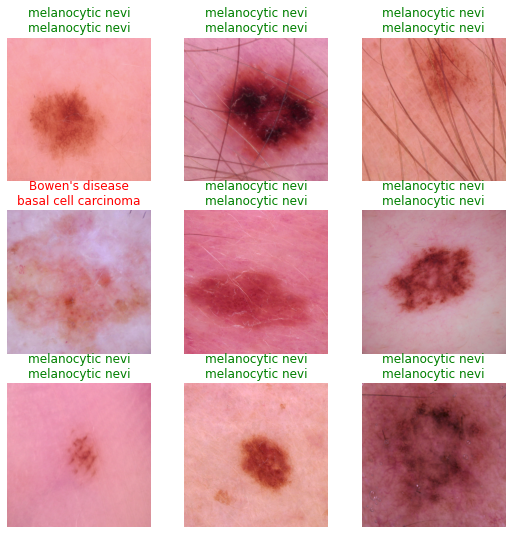

In [17]:
learn.show_results()


In [18]:
def predict(imgpath):
    display(PILImage.create(imgpath).to_thumb(128,128))
    pred,idx,probs = learn.predict(PILImage.create(imgpath))
    print(f"This is a: {pred}, with probability {probs[idx]:.4f}.")

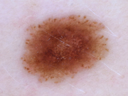

This is a: melanocytic nevi, with probability 0.9323.


In [19]:
predict('/content/HAM10000_images_part_1/ISIC_0024317.jpg')


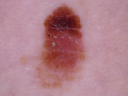

This is a: melanoma, with probability 0.6417.


In [34]:
predict("/content/HAM10000_images_part_1/ISIC_0024496.jpg")


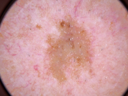

This is a: benign keratosis-like lesions, with probability 0.7382.


In [36]:
predict("/content/HAM10000_images_part_1/ISIC_0024498.jpg")
